In [1]:
import logging
from typing import List, Callable, Optional, Any

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.decompos

from randnn import ContinuousNN, get_attractor_dimension, scaling_analysis
from randnn.utils import np_cache
from randnn.plotting import *

In [2]:
rc('text', usetex=True)
logging.basicConfig(level=logging.INFO)

COUPLING_STRENGTH = 10
N_NEURONS = 1000

/Users/Jesse/Projects/masters-thesis/code/randnn/randnn/plotting.py:62: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = patches.Circle((0, 0),


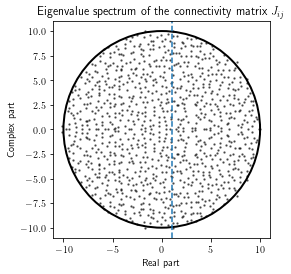

In [3]:
cont_nn = ContinuousNN(coupling_strength=COUPLING_STRENGTH, n_dofs=N_NEURONS, max_step=0.1)
## Plot the eigenvalue spectrum and make sure it respects Girko's circular law
plot_random_matrix_spectrum(cont_nn.coupling_matrix, COUPLING_STRENGTH)
plt.show()

INFO:root:Loading from save ./saves/trajectories/trajectory-51dc62de4bc0125a18cdd8fc9ffc1190.npy


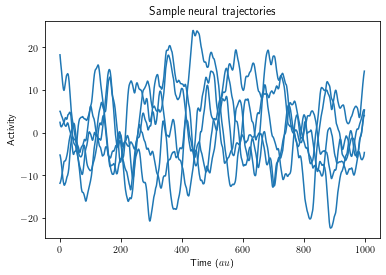

In [4]:
trajectory = cont_nn.run(n_steps=1000, n_burn_in=200)
plot_trajectory_samples(trajectory, 5)
plt.show()

INFO:root:Loading from save ./saves/lyapunov/spectrum-d54f8061d2c30924230185d3ac8f53ca.npy


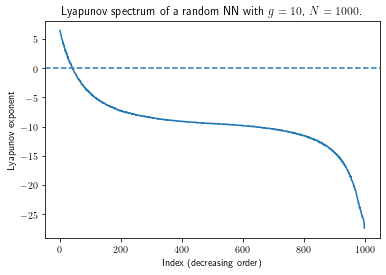

In [5]:
lyapunov_spectrum = cont_nn.get_lyapunov_spectrum(trajectory, t_ons=100)
plot_lyapunov_spectrum(lyapunov_spectrum, title="Lyapunov spectrum of a random NN with $g={}$, $N={}$.".format(COUPLING_STRENGTH, N_NEURONS))
plt.show()

In [6]:
#print("Attractor dimension: {}".format(get_attractor_dimension(lyapunov_spectrum)))

In [7]:
def get_pca_reduced_trajectory(coupling_strength=3, n_dofs=500, n_steps=1000, n_burn_in=200, t_ons=100):
    cont_nn = ContinuousNN(coupling_strength=coupling_strength, n_dofs=n_dofs, max_step=0.1)
    trajectory = cont_nn.run(n_steps=n_steps, n_burn_in=n_burn_in)
    lyapunov_spectrum = cont_nn.get_lyapunov_spectrum(trajectory, t_ons=t_ons)
    effective_dim = int(np.ceil(get_attractor_dimension(lyapunov_spectrum)))
    pca = sklearn.decomposition.PCA(effective_dim)
    return pca.fit_transform(trajectory)

response =get_pca_reduced_trajectory()
print(response.shape)



INFO:root:Loading from save ./saves/trajectories/trajectory-e82c50c599573a6aa51bfec8c38c5c08.npy
INFO:root:Loading from save ./saves/lyapunov/spectrum-461554943765eb166525a31a79204b30.npy


AttributeError: module 'sklearn' has no attribute 'decomposition'

In [ ]:
def init_fn(n_steps=1000, n_burn_in=200, t_ons=10, **kwargs):
    system = ContinuousNN(**kwargs)
    trajectory = system.run(n_steps=n_steps, n_burn_in=n_burn_in)
    return system.get_lyapunov_spectrum(trajectory, t_ons=t_ons)

analysis_fns = [get_attractor_dimension]
scaling_kwargs = [{"n_dofs": 10}, {"n_dofs": 100}, {"n_dofs": 500}, {"n_dofs": 1000}, {"n_dofs": 2000}, {"n_dofs":5000}]
init_kwargs = {"coupling_strength": COUPLING_STRENGTH, "t_ons": 200}

#dimensions = scaling_analysis(scaling_kwargs, init_fn, analysis_fns, init_kwargs)

In [ ]:
print(dimensions)
fig = plt.figure()
plt.title("Attractor dimension, $D$, with network size, $N$")
plt.ylabel("Attractor dimension, $D$")
plt.xlabel("Network size, $N$")
plt.plot(dimensions[:,0], dimensions[:,1], "-x")